# CustomCNN for CIFAR-10

This notebook implements a custom convolutional neural network using PyTorch. The network is built with a custom module called `ExpertBlock` that implements an expert branch (using fully connected layers and softmax) and multiple convolution branches. These blocks are stacked in the `Backbone`, and the final feature maps are fed through the `Classifier` head.

The notebook also includes training and evaluation functions for the CIFAR-10 dataset and plots training curves (loss and accuracy) at the end.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm  # For progress bars

# For plotting later
import matplotlib.pyplot as plt

# Checking for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on {device}")

Training on cuda


## ExpertBlock

The `ExpertBlock` consists of two main parts:

1. **Expert Branch:** This branch uses global average pooling and two fully connected layers (with a reduction factor) to compute a weight vector `a = [a1, ..., aK]` using softmax.
2. **Convolution Branch:** Contains `K` parallel convolutional layers (each with batch normalization and ReLU) whose outputs are weighted by the corresponding element in `a` and summed.

Finally, dropout is applied to the combined output.

In [ ]:
class ExpertBlock(nn.Module):
    """
    A single block in the backbone consisting of an expert branch and a convolution branch.
    """
    def __init__(self, in_channels, out_channels, K, r=2, dropout_prob=0.3):
        super(ExpertBlock, self).__init__()
        self.K = K
        self.dropout = nn.Dropout(dropout_prob)
        
        # Expert branch: generates weights vector using global average pooling and FC layers
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // r)   # reducing channel dimension
        self.fc2 = nn.Linear(in_channels // r, K)              # projecting to K elements
        
        # Convolution branch: K parallel convolutional layers
        self.conv_layers = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
            for _ in range(K)
        ])
        self.batch_norms = nn.ModuleList([
            nn.BatchNorm2d(out_channels) for _ in range(K)
        ])
        
    def forward(self, x):
        # Expert Branch
        pooled = self.avg_pool(x)              # shape: (B, in_channels, 1, 1)
        pooled = torch.flatten(pooled, 1)      # shape: (B, in_channels)
        reduced = self.fc1(pooled)             # shape: (B, in_channels//r)
        activated = torch.relu(reduced)
        expert_logits = self.fc2(activated)    # shape: (B, K)
        a = torch.softmax(expert_logits, dim=1)  # weight vector
        
        # Convolution Branch
        conv_outputs = []
        for conv, bn in zip(self.conv_layers, self.batch_norms):
            out = conv(x)
            out = bn(out)
            out = torch.relu(out)
            conv_outputs.append(out)
        
        # Combining outputs using the expert weights: sum(a[i]*conv_output[i])
        combined_output = 0
        for i in range(self.K):
            weight = a[:, i].view(-1, 1, 1, 1)  # reshaping for broadcast
            combined_output = combined_output + weight * conv_outputs[i]
        
        # Apply dropout
        combined_output = self.dropout(combined_output)
        return combined_output

## Backbone

The `Backbone` stacks multiple `ExpertBlock` modules. The number of blocks and their output channel dimensions are configurable. This module serves as the feature extractor.

In [3]:
class Backbone(nn.Module):
    """
    Backbone composed of N ExpertBlocks.
    """
    def __init__(self, num_blocks, in_channels, block_channels, K, r, dropout_prob=0.3):
        super(Backbone, self).__init__()
        layers = []
        current_channels = in_channels
        for out_channels in block_channels:
            layers.append(ExpertBlock(current_channels, out_channels, K, r, dropout_prob))
            current_channels = out_channels
        self.blocks = nn.ModuleList(layers)
        
    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x

## Classifier

The `Classifier` takes the feature maps produced by the backbone and applies an adaptive average pooling followed by a fully connected layer to produce the final class scores.

In [4]:
class Classifier(nn.Module):
    """
    Classification head that applies adaptive average pooling and a final linear layer.
    """
    def __init__(self, in_channels, num_classes):
        super(Classifier, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_channels, num_classes)
        
    def forward(self, x):
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

## CustomCNN

The `CustomCNN` model combines all the previous components:

 - **Stem:** An initial convolutional layer that converts the 3-channel input into a higher dimensional representation.
 - **Backbone:** A series of `ExpertBlock` modules to extract complex features.
 - **Classifier:** A final classification head that outputs the class predictions for CIFAR-10.

In [ ]:
class CustomCNN(nn.Module):
    """
    Complete network with a stem, backbone (ExpertBlocks), and classifier.
    """
    def __init__(self, num_blocks=3, K=2, r=2, dropout_prob=0.2, num_classes=10):
        super(CustomCNN, self).__init__()
        # Stem: initial convolutional layer
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        # Defining output channels for each ExpertBlock
        if num_blocks == 3:
            block_channels = [64, 128, 256]
        else:
            block_channels = [32 * (2 ** i) for i in range(1, num_blocks + 1)]
        
        # Backbone composed of ExpertBlocks
        self.backbone = Backbone(num_blocks, in_channels=32, block_channels=block_channels,
                                 K=K, r=r, dropout_prob=dropout_prob)
        # Classifier head
        self.classifier = Classifier(in_channels=block_channels[-1], num_classes=num_classes)
        
    def forward(self, x):
        x = self.stem(x)        # initial feature extraction
        x = self.backbone(x)    # backbone processing
        x = self.classifier(x)  # final classification
        return x

## Training and Evaluation Functions

The following functions implement the training and evaluation loops:

 - **train:** Sets the model to training mode, iterates over the training dataset with a progress bar, computes the loss, backpropagates, and updates the weights.
 - **evaluate:** Sets the model to evaluation mode, computes the loss on the test dataset, and calculates accuracy.

In [6]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss


def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(test_loader.dataset)
    accuracy = 100 * correct / total
    return epoch_loss, accuracy

## Main Execution: Data Loading, Training, and Evaluation

This cell handles:

 - Loading the CIFAR-10 dataset and defining data transformations
 - Initializing the model, loss function, optimizer, and a learning rate scheduler
 - Running the training loop over a specified number of epochs while recording metrics
 - Saving the trained model

The metrics (training loss, test loss, and test accuracy) are stored for plotting later.

In [ ]:
def main():
    # Hyperparameters
    num_epochs = 15
    batch_size = 128
    learning_rate = 0.001
    
    # data transformations
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), 
                             (0.2023, 0.1994, 0.2010)),
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), 
                             (0.2023, 0.1994, 0.2010)),
    ])
    
    # Loading the dataset
    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                 download=True, transform=transform_train)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                                download=True, transform=transform_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    # Initializing model, loss function, and optimizer
    model = CustomCNN(num_blocks=3, K=2, r=2, dropout_prob=0.2, num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Learning Rate Scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    
    # Lists to record training metrics
    train_loss_history = []
    test_loss_history = []
    test_accuracy_history = []
    
    # Training loop
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        train_loss = train(model, train_loader, criterion, optimizer, device)
        test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
        print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%")
        scheduler.step()  # Update learning rate
        
        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)
        test_accuracy_history.append(test_accuracy)
    
    # Saving the trained model
    torch.save(model.state_dict(), "cifar10_customcnn.pth")
    print("Model saved as cifar10_customcnn.pth")
    
    return train_loss_history, test_loss_history, test_accuracy_history


if __name__ == "__main__":
    metrics = main()

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/15


Train Loss: 1.5065 | Test Loss: 1.3562 | Test Accuracy: 50.22%
Epoch 2/15


Train Loss: 1.1930 | Test Loss: 1.3021 | Test Accuracy: 55.62%
Epoch 3/15


Train Loss: 1.0717 | Test Loss: 1.2252 | Test Accuracy: 56.48%
Epoch 4/15


Train Loss: 0.9965 | Test Loss: 1.1877 | Test Accuracy: 59.60%
Epoch 5/15


Train Loss: 0.9328 | Test Loss: 1.0119 | Test Accuracy: 64.97%
Epoch 6/15


Train Loss: 0.8192 | Test Loss: 0.8320 | Test Accuracy: 70.99%
Epoch 7/15


Train Loss: 0.7960 | Test Loss: 0.8391 | Test Accuracy: 70.55%
Epoch 8/15


Train Loss: 0.7827 | Test Loss: 0.8459 | Test Accuracy: 70.36%
Epoch 9/15


Train Loss: 0.7739 | Test Loss: 0.8069 | Test Accuracy: 71.96%
Epoch 10/15


Train Loss: 0.7672 | Test Loss: 0.8279 | Test Accuracy: 71.33%
Epoch 11/15


Train Loss: 0.7464 | Test Loss: 0.7759 | Test Accuracy: 72.99%
Epoch 12/15


Train Loss: 0.7451 | Test Loss: 0.7724 | Test Accuracy: 72.92%
Epoch 13/15


Train Loss: 0.7427 | Test Loss: 0.7771 | Test Accuracy: 73.23%
Epoch 14/15


Train Loss: 0.7398 | Test Loss: 0.7710 | Test Accuracy: 73.24%
Epoch 15/15


Train Loss: 0.7411 | Test Loss: 0.7662 | Test Accuracy: 73.33%
Model saved as cifar10_customcnn.pth


## Plotting the Training Metrics

The following cell plots the training loss, test loss, and test accuracy over the epochs.

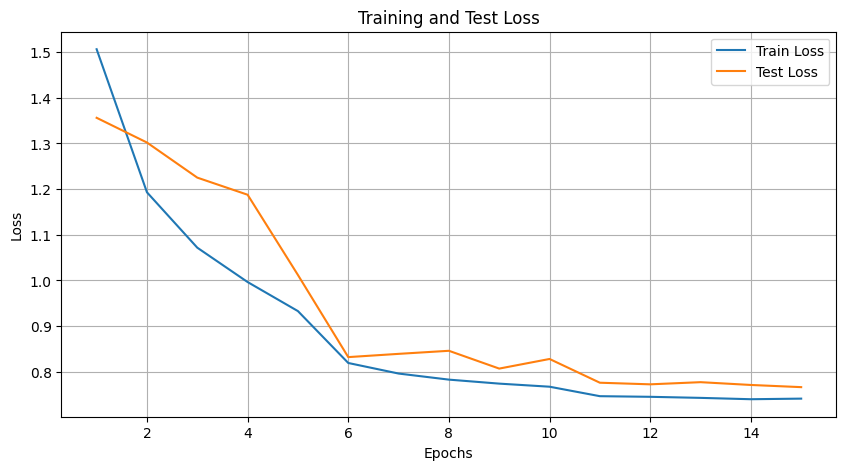

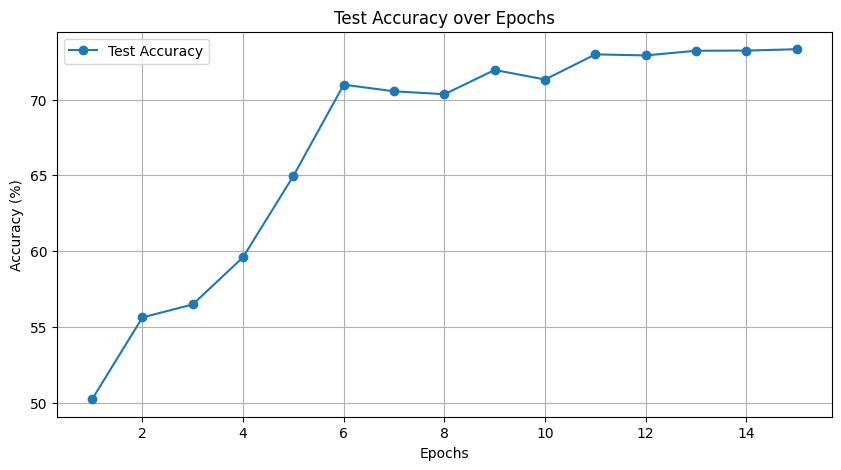

In [ ]:
import matplotlib.pyplot as plt

# Unpacking the recorded metrics
train_loss_history, test_loss_history, test_accuracy_history = metrics
epochs = range(1, len(train_loss_history) + 1)

# Plotting Training and Test Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_history, label='Train Loss')
plt.plot(epochs, test_loss_history, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Test Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, test_accuracy_history, label='Test Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()
